In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *

In [3]:
path = Path('imgs')

In [4]:
path.ls()

(#2) [Path('imgs/test'),Path('imgs/train')]

In [5]:
train = path/"train"

In [6]:
train.ls()

(#10) [Path('imgs/train/c0'),Path('imgs/train/c1'),Path('imgs/train/c2'),Path('imgs/train/c3'),Path('imgs/train/c4'),Path('imgs/train/c5'),Path('imgs/train/c6'),Path('imgs/train/c7'),Path('imgs/train/c8'),Path('imgs/train/c9')]

In [7]:
fns = get_image_files(train)
fns

(#22424) [Path('imgs/train/c0/img_100026.jpg'),Path('imgs/train/c0/img_10003.jpg'),Path('imgs/train/c0/img_100050.jpg'),Path('imgs/train/c0/img_100074.jpg'),Path('imgs/train/c0/img_10012.jpg'),Path('imgs/train/c0/img_100145.jpg'),Path('imgs/train/c0/img_100191.jpg'),Path('imgs/train/c0/img_100257.jpg'),Path('imgs/train/c0/img_100312.jpg'),Path('imgs/train/c0/img_100337.jpg')...]

In [8]:
failed = verify_images(fns)
failed

(#0) []

In [9]:
failed.map(Path.unlink)

(#0) []

In [10]:
fns[0]

Path('imgs/train/c0/img_100026.jpg')

In [11]:
def get_y(p):
    return [parent_label(p)]

In [12]:
def get_dls(bs, size):
    dBlock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                       get_items = get_image_files,
                       splitter = RandomSplitter(valid_pct = .2, seed=42),
                       get_y = get_y,
                       item_tfms = Resize(size),
                       batch_tfms = aug_transforms(size=size, min_scale=0.75))
    return dBlock.dataloaders(train, num_workers=0, bs=bs)

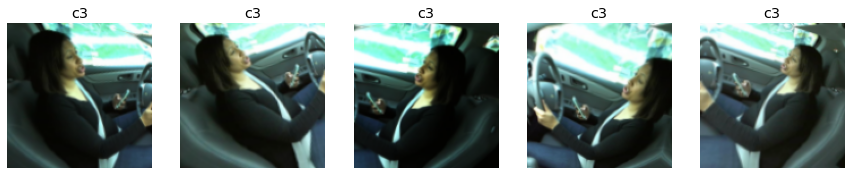

In [13]:
dls = get_dls(128, 128)
dls.train.show_batch(max_n=5, nrows=1, unique=True)

In [61]:
learn = cnn_learner(dls,resnet34,metrics=accuracy_multi)
learn.fit_one_cycle(3,3e-3)
learn.unfreeze()
learn.fit_one_cycle(6,lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.341683,0.101559,0.962400,02:33
1,0.081237,0.036255,0.987623,02:30
2,0.046410,0.029689,0.990343,02:28


SuggestedLRs(lr_min=3.311311302240938e-05, lr_steep=1.9054607491852948e-06)

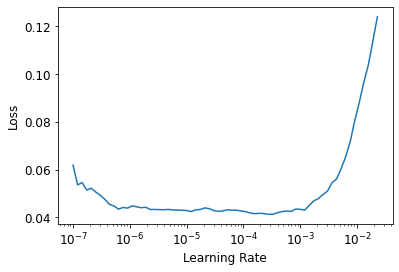

In [62]:
learn.unfreeze()
learn.lr_find()

In [63]:

learn.fit_one_cycle(6,lr_max=slice(0.00014454397605732084,0.0003311311302240938))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.039517,0.025943,0.992083,02:41
1,0.032419,0.019549,0.994179,02:40
2,0.026324,0.015718,0.995250,02:37
3,0.022240,0.013700,0.996187,02:37
4,0.020548,0.013148,0.996343,02:37
5,0.019288,0.012908,0.996409,02:37


In [15]:
learn.fine_tune(4, 3e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.451587,0.213490,0.921186,02:35


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.071809,0.034349,0.989719,02:43
1,0.023717,0.010550,0.996722,02:40
2,0.010204,0.006273,0.998104,02:44
3,0.006265,0.005574,0.998283,02:42


In [42]:
preds,targs = learn.get_preds()

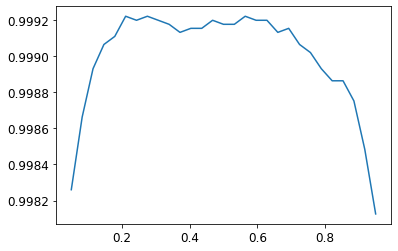

In [43]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs)

In [44]:
learn.validate()

(#2) [0.00280477455817163,0.9991747736930847]

In [45]:
learn.export()

In [46]:
learn = load_learner("export.pkl")

Add some CAM stuff

In [47]:
learn.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

Do testy test on stuff

In [48]:
test = path/"test"

In [49]:
test.ls()

(#79726) [Path('imgs/test/img_1.jpg'),Path('imgs/test/img_10.jpg'),Path('imgs/test/img_100.jpg'),Path('imgs/test/img_1000.jpg'),Path('imgs/test/img_100000.jpg'),Path('imgs/test/img_100001.jpg'),Path('imgs/test/img_100002.jpg'),Path('imgs/test/img_100003.jpg'),Path('imgs/test/img_100004.jpg'),Path('imgs/test/img_100005.jpg')...]

In [50]:
test_gif = get_image_files(test)
test_gif

(#79726) [Path('imgs/test/img_1.jpg'),Path('imgs/test/img_10.jpg'),Path('imgs/test/img_100.jpg'),Path('imgs/test/img_1000.jpg'),Path('imgs/test/img_100000.jpg'),Path('imgs/test/img_100001.jpg'),Path('imgs/test/img_100002.jpg'),Path('imgs/test/img_100003.jpg'),Path('imgs/test/img_100004.jpg'),Path('imgs/test/img_100005.jpg')...]

In [51]:
failed_test_gif = verify_images(test_gif)
failed_test_gif

(#0) []

In [52]:
failed_test_gif.map(Path.unlink)

(#0) []

In [53]:
batchSize = 64*2**0
batchSize

64

In [54]:
dl = learn.dls.test_dl(test_gif, bs=batchSize)
predictions,  _ = learn.get_preds(dl=dl)

In [55]:
import math

In [58]:
from pathlib import Path
dfv = pd.read_csv("sample_submission.csv", index_col="img")

def EvaluateNumber(x):
    return x

i = 0
for test_img in test_gif:
    fileName = test_img.stem + test_img.suffix
    dfv.loc[fileName] = [EvaluateNumber(predictions[i][0].item()),
                         EvaluateNumber(predictions[i][1].item()),
                         EvaluateNumber(predictions[i][2].item()),
                         EvaluateNumber(predictions[i][3].item()),
                         EvaluateNumber(predictions[i][4].item()),
                         EvaluateNumber(predictions[i][5].item()),
                         EvaluateNumber(predictions[i][6].item()),
                         EvaluateNumber(predictions[i][7].item()),
                         EvaluateNumber(predictions[i][8].item()),
                         EvaluateNumber(predictions[i][9].item())]
    i = i + 1
    
dfv

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
img,,,,,,,,,,
img_1.jpg,0.000137,0.000080,0.000085,0.001845,0.000024,0.999603,0.000098,0.000135,0.000373,0.000171
img_10.jpg,0.000113,0.000216,0.000093,0.000129,0.000030,0.998733,0.000119,0.000210,0.005037,0.000082
img_100.jpg,0.058814,0.000666,0.005321,0.100583,0.006861,0.001860,0.005991,0.002595,0.235375,0.005791
img_1000.jpg,0.000446,0.000019,0.000610,0.000250,0.000199,0.000146,0.000184,0.000058,0.997702,0.000545
img_100000.jpg,0.000683,0.000016,0.000179,0.997951,0.002151,0.000256,0.000750,0.000657,0.001412,0.000869
...,...,...,...,...,...,...,...,...,...,...
img_99994.jpg,0.001439,0.996274,0.000476,0.000114,0.000351,0.000853,0.000327,0.001417,0.000695,0.001097
img_99995.jpg,0.001767,0.000093,0.000058,0.998382,0.000492,0.000070,0.001728,0.000327,0.000606,0.000174
img_99996.jpg,0.000088,0.000130,0.000284,0.000562,0.999337,0.000074,0.000072,0.000192,0.001186,0.000416


In [60]:
dfv.to_csv("submission.csv")